In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
from mpl_toolkits.basemap import Basemap

#### My goal: to understand roughly what the different SCONCE methods do, the type of input I have to give them, and what to expect from them

## Example 1: Mode-seeking on a 2D Gaussian mixture density

In [3]:
from sconce.utils import cart2sph, sph2cart, GaussMixture, vMFMixtureSamp, vMFGaussMixture
from sconce.EucSCMS import KDE, MS
from sconce.DirSCMS import DirKDE, DirMS
from sconce.DirLinSCMS import DirLinKDE, DirLinMS

import ray
from sconce.EucSCMS_RayFunc import MS_Ray
from sconce.DirSCMS_RayFunc import DirMS_Ray
from sconce.DirLinSCMS_RayFunc import DirLinMS_Ray

In [4]:
# Set up the parameters for the Gaussian mixture model
mu = np.array([[1,1], [-1,-1]])
cov = np.zeros((2,2,2))
cov[:,:,0] = np.diag([1/4,1/4])
cov[:,:,1] = np.array([[1/2,1/4], [1/4,1/2]])
prob = [0.4, 0.6]

np.random.seed(123)  ## Set an arbitrary seed for reproducibility
Gau_data = GaussMixture(2000, mu=mu, cov=cov, prob=prob)

# Estimate the densities on query points
n_x = 100
n_y = 100
x = np.linspace(-3.5, 3.5, n_x)
y = np.linspace(-3.5, 3.5, n_y)
X, Y = np.meshgrid(x, y)
query_pts = np.concatenate((X.reshape(n_x*n_y, 1), Y.reshape(n_x*n_y, 1)), axis=1)
d_hat1 = KDE(query_pts, Gau_data, h=None)
Z1 = d_hat1.reshape(n_x, n_y)

The current bandwidth is 0.32893476047421333.



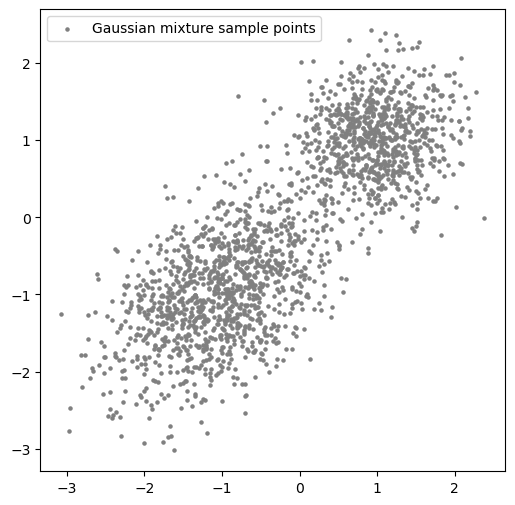

In [6]:
fig = plt.figure(figsize=(6,6))
# X_m = EuModes[:,0]
# Y_m = EuModes[:,1]
# plt.contour(X, Y, Z1, cmap='viridis')
plt.scatter(Gau_data[:,0], Gau_data[:,1], color='grey', s=5, label='Gaussian mixture sample points')
# plt.scatter(X_m, Y_m, s=40, color='red', label='Mean shift local modes')
lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
# lgnd.legendHandles[0]._sizes = [50]
# lgnd.legendHandles[1]._sizes = [50]
plt.show()

In [14]:
# Apply the standard MS algorithm to the Gaussian mixture dataset
MS_path = MS(Gau_data, Gau_data, h=None, eps=1e-9, max_iter=1000, wt=None)
EuModes = MS_path[:,:,MS_path.shape[2]-1]

The current bandwidth is 0.32893476047421333.

The MS algorithm converges in 179steps!


### MS: 

Parameters:
------------------
    mesh_0: a (m,d)-array
        The coordinates of m initial points in the d-dim Euclidean space.

    data: a (n,d)-array
        The coordinates of n data sample points in the d-dim Euclidean space.
        
        
Question: what is the difference between mesh_0 and data? I mean, what those m initial points in d-dim need to be? Can I always use mesh_0 = data when running this MS function?

In [18]:
MS_path.shape

(2000, 2, 180)

In [19]:
EuModes.shape

(2000, 2)

Why is EuModes defined like this (EuModes = MS_path[:,:,MS_path.shape[2]-1])?

In [28]:
plt.contour?

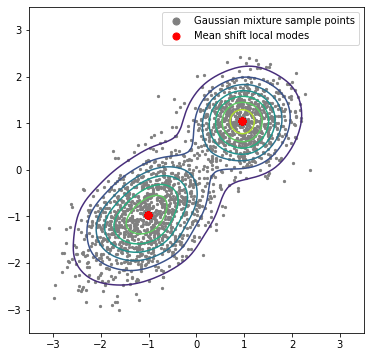

In [20]:
fig = plt.figure(figsize=(6,6))
X_m = EuModes[:,0]
Y_m = EuModes[:,1]
plt.contour(X, Y, Z1, cmap='viridis')
plt.scatter(Gau_data[:,0], Gau_data[:,1], color='grey', s=5, label='Gaussian mixture sample points')
plt.scatter(X_m, Y_m, s=40, color='red', label='Mean shift local modes')
lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.show()

#### Let's try to apply this to Hydra-Centaurus

In [3]:
table = pd.read_csv("tables_photometric/Hydra-Centaurus-Gaia-Crossmatch.csv", 
                    usecols=["RA_2", "DEC_2", "PROB_GAL", "zml", "r_petro", "g_petro"])

In [4]:
ra = table["RA_2"]
dec = table["DEC_2"]
probgal = table["PROB_GAL"]
zml = table["zml"]
rpetro = table["r_petro"]
gpetro = table["g_petro"]

In [5]:
mlim = 21
ra_max = 185
dec_min = -55
mask = (rpetro < mlim) & (zml > 0.005) & (zml < 0.03) & (ra < ra_max) & (dec > dec_min)

In [6]:
#vstack and transpose matrix in order to let it in the right shape to be used
HC_data = np.vstack([ra[mask], dec[mask]]).T

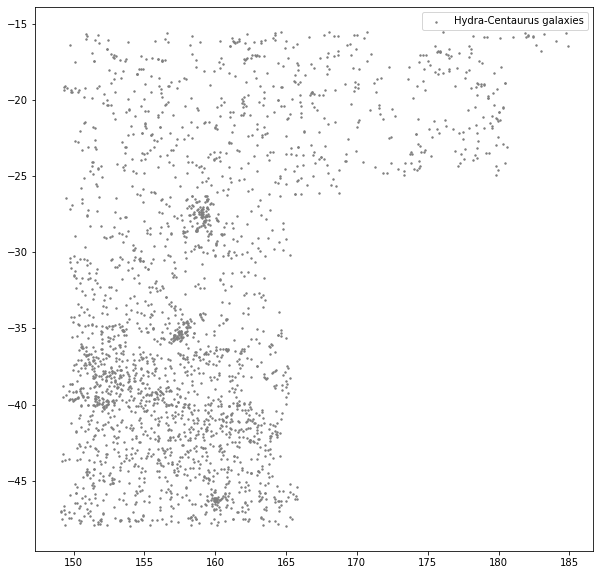

In [8]:
fig = plt.figure(figsize=(10,10))
plt.scatter(HC_data[:,0], HC_data[:,1], color='grey', s=2, label='Hydra-Centaurus galaxies')
lgnd = plt.legend(numpoints=1)
plt.show()

In [ ]:
# Apply the standard MS algorithm to the Gaussian mixture dataset
MS_path = MS(HC_data, HC_data, h=None, eps=1e-9, max_iter=1000, wt=None)
EuModes = MS_path[:,:,MS_path.shape[2]-1]

In [26]:
# Estimate the densities on query points
n_x = 100
n_y = 100
x = np.linspace(ra[mask].min(), ra[mask].max(), n_x)
y = np.linspace(dec[mask].min(), dec[mask].max(), n_y)
X, Y = np.meshgrid(x, y)
query_pts = np.concatenate((X.reshape(n_x*n_y, 1), Y.reshape(n_x*n_y, 1)), axis=1)
d_hat1 = KDE(query_pts, HC_data, h=None)
Z1 = d_hat1.reshape(n_x, n_y)

The current bandwidth is 1.3601955437840243.



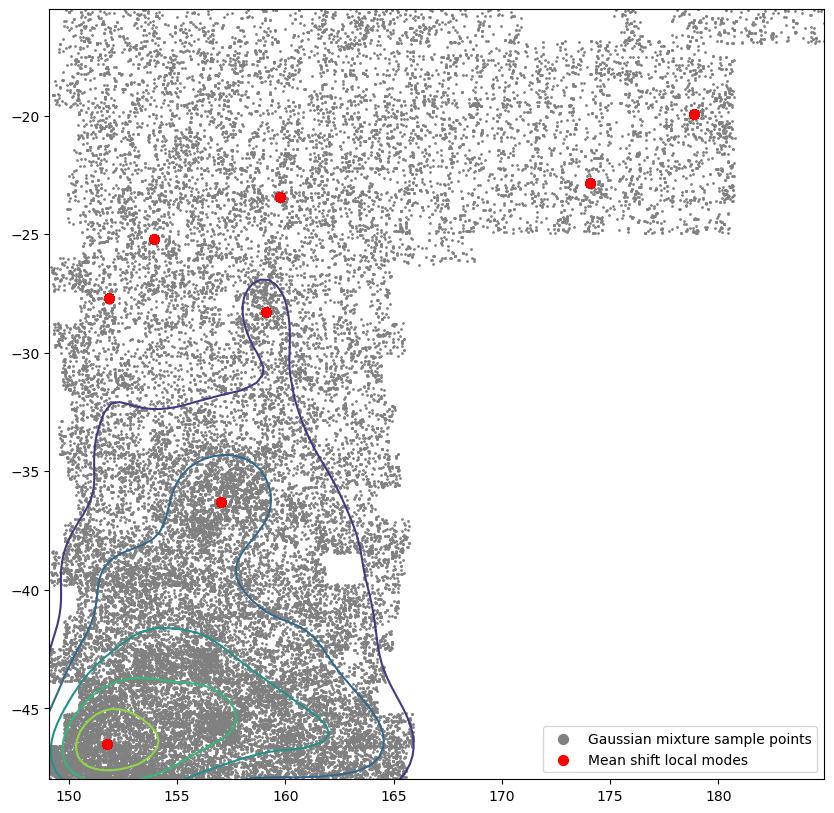

In [30]:
fig = plt.figure(figsize=(10,10))
X_m = EuModes[:,0]
Y_m = EuModes[:,1]
plt.contour(X, Y, Z1, cmap='viridis')
plt.scatter(HC_data[:,0], HC_data[:,1], color='grey', s=1, label='Gaussian mixture sample points')
plt.scatter(X_m, Y_m, s=40, color='red', label='Mean shift local modes')
lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.show()

## Example 2: A circle crossing the north and south poles on the unit sphere $\mathbb{S}^2$

In [10]:
from sconce.utils import cart2sph, sph2cart, CirSphSampling
from sconce.EucSCMS import KDE, SCMSLog
from sconce.DirSCMS import DirKDE, DirSCMSLog
from sconce.DirLinSCMS import DirLinSCMSLog

import ray
from sconce.EucSCMS_RayFunc import SCMSLog_Ray
from sconce.DirSCMS_RayFunc import DirSCMSLog_Ray
from sconce.DirLinSCMS_RayFunc import DirLinSCMSLog_Ray

In [6]:
np.random.seed(123)  # Set an arbitrary seed for reproducibility
# Sampling the points on a circle that crosses through the north and south poles
cir_samp = CirSphSampling(2000, lat_c=0, lon_range=[-180,180], sigma=0.1, pv_ax=np.array([1,0,0]))

true_cur = CirSphSampling(2000, lat_c=0, lon_range=[-180,180], sigma=0, pv_ax=np.array([1,0,0]))

lon_c, lat_c, r = cart2sph(*cir_samp.T)
cir_samp_ang = np.concatenate((lon_c.reshape(len(lon_c),1),
                               lat_c.reshape(len(lat_c),1)), axis=1)

d_hat_dat = DirKDE(cir_samp, cir_samp, h=None)

The current bandwidth is 0.7592252306206649.



In [7]:
cir_samp_ang.shape

(2000, 2)

### DirKDE 
computes the directional KDE using the von Mises Kernel. <br>

Parameters
-----------------
    x: (m,d)-array
        The Eulidean coordinates of m query points on a unit hypersphere, 
        where d=q+1 is the Euclidean dimension of data

    data: (n,d)-array
        The Euclidean coordinates of n directional random sample points in 
        the d-dimensional Euclidean space.
        
The question I always have in these KDE functions is what exactly are these "query points"? Are they the points the density will be estimated or something?

In [5]:
SCMS_Eu_log = SCMSLog(cir_samp_ang, data=cir_samp_ang, d=1, h=None, eps=1e-7, max_iter=5000)
Eu_ridge_log = SCMS_Eu_log[:,:,SCMS_Eu_log.shape[2]-1]

The current bandwidth is 20.062747464932812.

The SCMS algorithm converges in 166steps!


### SCMSLog

Subspace Constrained Mean Shift algorithm with log density and Gaussian kernel.

Parameters
----------
    mesh_0: a (m,D)-array
        The coordinates of m initial points in the D-dim Euclidean space.

    data: a (n,D)-array
        The coordinates of n data sample points in the D-dim Euclidean space.
   
    d: int
        The order of the density ridge.
   
    h: float
        The bandwidth parameter. (Default: h=None. Then the Silverman's 
        rule of thumb is applied. See Chen et al.(2016) for details.)
        
Aparently, "mesh_0" and "data" here are the same inputs I use to run the "MS" function earlier.

### Aparently this is the result for the standard SCMS algorithm, which is not so good (?)

/home/elismar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':


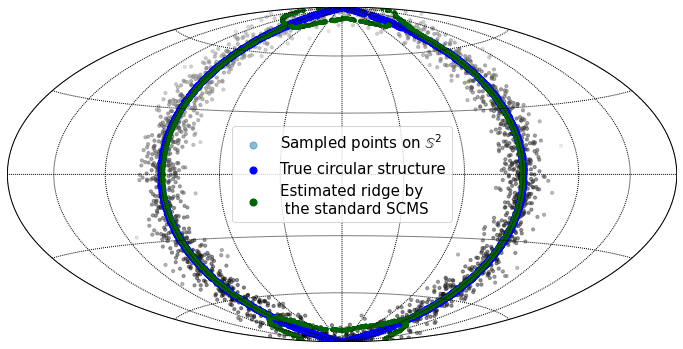

In [8]:
plt.rcParams.update({'font.size': 15})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(12,10))
lon_p, lat_p, r = cart2sph(*cir_samp.T)
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_r_Eu = Eu_ridge_log[:,0]
lat_r_Eu = Eu_ridge_log[:,1]
# Set up map projection
m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
             llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x_p, y_p = m1(lon_p, lat_p)
x_t, y_t = m1(lon_t, lat_t)
x_Eu, y_Eu = m1(lon_r_Eu, lat_r_Eu)
# Scatter plots over the map.
cs = m1.scatter(x_p, y_p, c=1/(d_hat_dat)**(1/20), s=10, cmap='gray', alpha=0.5,
                label='Sampled points on $\mathbb{S}^2$')
cs = m1.scatter(x_t, y_t, color='blue', s=40, alpha=1, label='True circular structure')
cs = m1.scatter(x_Eu, y_Eu, color='darkgreen', s=15, alpha=1,
                label='Estimated ridge by \n the standard SCMS')
lgnd = plt.legend(loc='center', numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
plt.show()

### So it's better to apply the DirSCMS algorithm:

In [9]:
SCMS_Dir_log = DirSCMSLog(cir_samp, data=cir_samp, d=1, h=None, eps=1e-7, max_iter=5000)
Dir_ridge_log = SCMS_Dir_log[:,:,SCMS_Dir_log.shape[2]-1]

The current bandwidth is 0.7592252306206649.

The directional SCMS algorithm converges in 6steps!


/home/elismar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


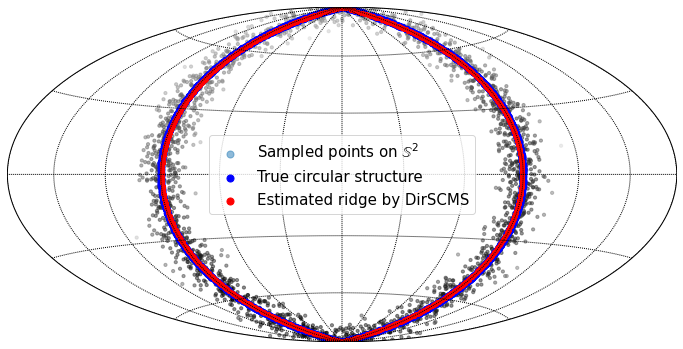

In [10]:
plt.rcParams.update({'font.size': 15})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(12,10))
lon_p, lat_p, r = cart2sph(*cir_samp.T)
lon_t, lat_t, r = cart2sph(*true_cur.T)
lon_r_Dir, lat_r_Dir, r = cart2sph(*Dir_ridge_log.T)
# Set up map projection
m1 = Basemap(projection='hammer', llcrnrlon=-180, urcrnrlon=180,
             llcrnrlat=-90, urcrnrlat=90, resolution='c', lon_0=0)
# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))
# Compute native map projection coordinates of lat/lon grid.
x_p, y_p = m1(lon_p, lat_p)
x_t, y_t = m1(lon_t, lat_t)
x_Dir, y_Dir = m1(lon_r_Dir, lat_r_Dir)
# Scatter plots over the map.
cs = m1.scatter(x_p, y_p, c=1/(d_hat_dat)**(1/20), s=10, cmap='gray', alpha=0.5,
                label='Sampled points on $\mathbb{S}^2$')
cs = m1.scatter(x_t, y_t, color='blue', s=40, alpha=1, label='True circular structure')
cs = m1.scatter(x_Dir, y_Dir, color='red', s=15, alpha=1,
                label='Estimated ridge by DirSCMS')
lgnd = plt.legend(loc='center', numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
lgnd.legendHandles[2]._sizes = [50]
plt.show()

#### A question I have is: can I apply this DirSCMS function to find filaments in a set of points (like galaxies in a supercluster)?

### Let's apply this for Hydra-Centaurus

In [11]:
#For what I understood, we have to input the euclidean (cartesian?) coordinates of m points in D-dimensional 
#euclidian space to DirSCMSLog. 
from astropy.coordinates import spherical_to_cartesian

In [12]:
def convert_to_cartesian(ra, dec):
    x, y, z = spherical_to_cartesian(r=1, lon=np.deg2rad(ra), lat=np.deg2rad(dec))
    return x, y, z

x, y, z = convert_to_cartesian(ra[mask], dec[mask])

In [13]:
HC_data_cartesian = np.vstack([x.value, y.value, z.value]).T

In [14]:
HC_data_cartesian.shape

(2516, 3)

In [15]:
SCMS_Dir_log = DirSCMSLog(HC_data_cartesian, data=HC_data_cartesian, d=1, h=None, eps=1e-7, max_iter=5000)
Dir_ridge_log = SCMS_Dir_log[:,:,SCMS_Dir_log.shape[2]-1]

The current bandwidth is 0.03672327347199116.

The directional SCMS algorithm converges in 505steps!


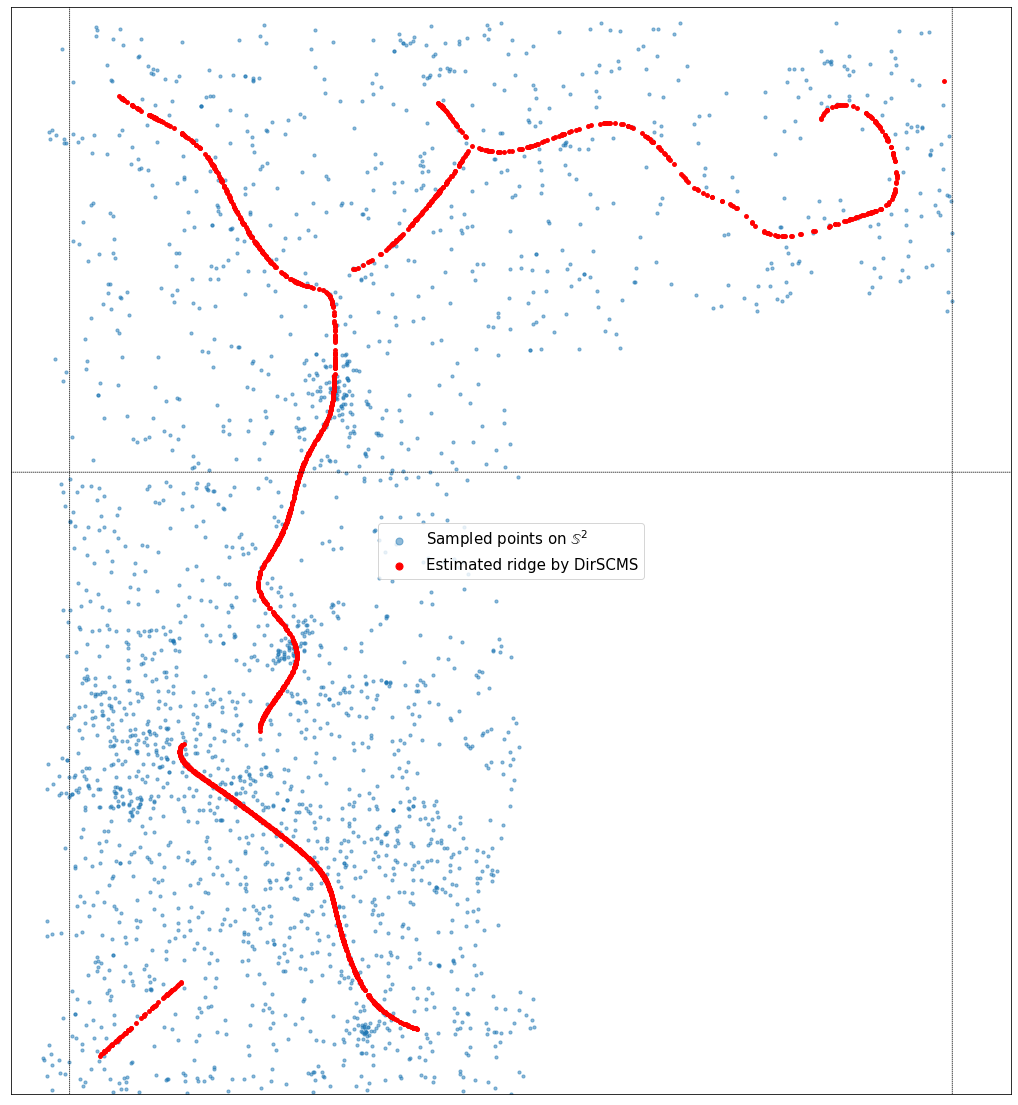

In [16]:
plt.rcParams.update({'font.size': 15})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(20,20))

lon_p, lat_p, r = cart2sph(*HC_data_cartesian.T)
lon_r_Dir, lat_r_Dir, r = cart2sph(*Dir_ridge_log.T)

# Set up map projection
m1 = Basemap(projection='mill', llcrnrlon=148, urcrnrlon=182,
             llcrnrlat=-48, urcrnrlat=-15, resolution='c', lon_0=0)

# Draw lat/lon grid lines every 30 degrees.
m1.drawmeridians(np.arange(-180, 180, 30))
m1.drawparallels(np.arange(-90, 90, 30))

# Compute native map projection coordinates of lat/lon grid.
x_p, y_p = m1(lon_p, lat_p)
x_Dir, y_Dir = m1(lon_r_Dir, lat_r_Dir)

# Scatter plots over the map.
cs = m1.scatter(x_p, y_p, s=10, cmap='gray', alpha=0.5,
                label='Sampled points on $\mathbb{S}^2$')
cs = m1.scatter(x_Dir, y_Dir, color='red', s=15, alpha=1,
                label='Estimated ridge by DirSCMS')

lgnd = plt.legend(loc='center', numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]

plt.show()

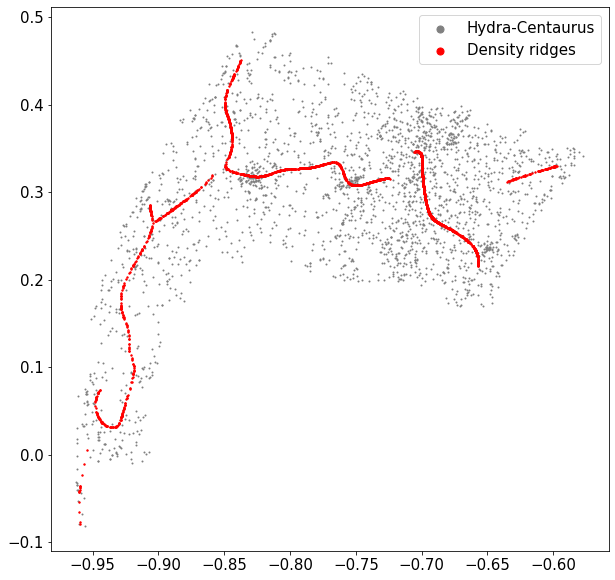

In [17]:
fig = plt.figure(figsize=(10,10))

plt.scatter(HC_data_cartesian[:,0], HC_data_cartesian[:,1], color='grey', 
                s=1, label='Hydra-Centaurus')
plt.scatter(Dir_ridge_log[:, 0], Dir_ridge_log[:, 1], s=2, color='red', label='Density ridges')
lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
plt.show()